## Dataset


In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Downloadanje

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print("Path to dataset files:", path)

100%|██████████| 612M/612M [00:05<00:00, 114MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1


### Kopiranje u Colab folder

In [3]:
!cp -r /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1 /content/gtsrb-german-traffic-sign

## Priprema podataka

### Učitavanje podataka

In [4]:
import os
import cv2
import numpy as np

train_folder = "/content/gtsrb-german-traffic-sign/Train"
categories = 43
image_size = (64, 64)

train_images = []
train_labels = []

resnet_train_images = []
resnet_train_labels = []

for label in range(categories):
    category_path = os.path.join(train_folder, str(label)) # folder path
    image_files = os.listdir(category_path)

    for image_file in image_files:
        image_path = os.path.join(category_path, image_file)
        image = cv2.imread(image_path)

        if image is not None:
            image = cv2.resize(image, image_size)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            train_images.append(image)
            train_labels.append(label)

train_images = np.array(train_images)
train_labels = np.array(train_labels)

print("Shape of train_images:", train_images.shape)  # (num_images, 32, 32, 3)
print("Shape of train_labels:", train_labels.shape)  # (num_images,)
# broj primjera, dimenzija x dimenzija, broj kanala (RGB pa je 3)

Shape of train_images: (39209, 64, 64, 3)
Shape of train_labels: (39209,)


In [5]:
print("Train labels head: ", train_labels[:5])  # [0 0 0 0 0]

Train labels head:  [0 0 0 0 0]


### Visualizacija dijela podataka

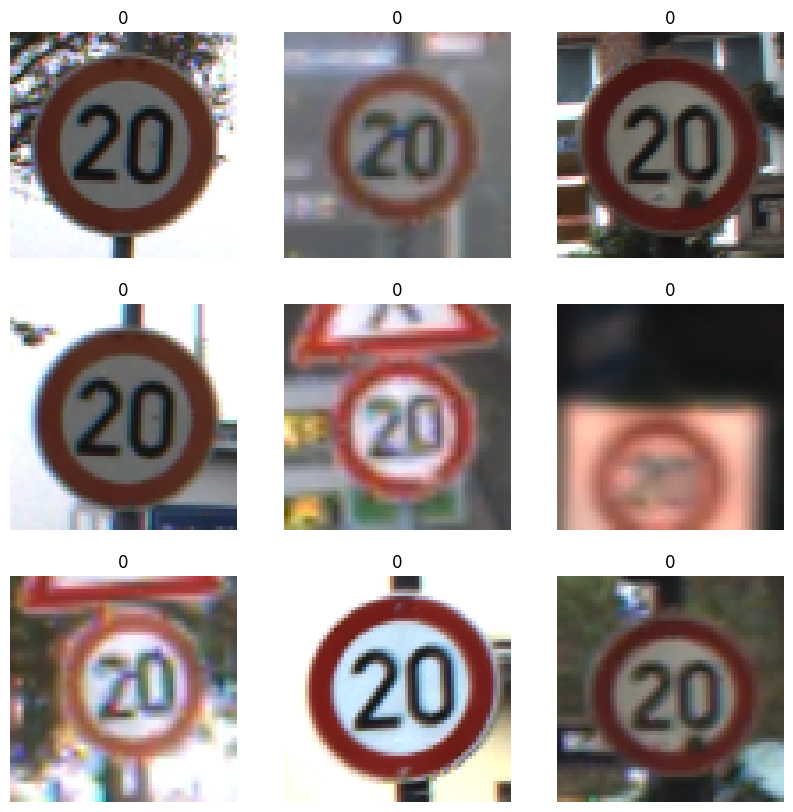

In [6]:
# visualize 9 images in 3x3 grid
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

# sve slike ce bit slike iz prve klase jer su tak stavljene u numpy array
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_images[i])
    plt.title(train_labels[i])
    plt.axis('off')

plt.show()

### Podjela na skup za treniranje i testiranje

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

X_train shape: (31367, 64, 64, 3)
X_val shape: (7842, 64, 64, 3)
y_train shape: (31367,)
y_val shape: (7842,)


## Treniranje modela

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np

class TrafficSignDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images # input, odnosno X
        self.labels = labels # output, odnosno y
        self.transform = transform # transformacija podataka

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx): # vrati odredeni X (transformirani) i y
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)), # zelimo 64x64
    transforms.ToTensor(), # pretvori u tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # normalizacija svih piksela
])

train_dataset = TrafficSignDataset(X_train, y_train, transform=transform)
val_dataset = TrafficSignDataset(X_val, y_val, transform=transform)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### Definiranje arhitekture modela

In [9]:
import torch.nn as nn
import torch

class CNNModel(nn.Module):
    def __init__(self, num_classes=43):
        super(CNNModel, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  # filter od 3x3, 32 filtera
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) # veci feature map (s 32 na 64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # klasicni max pooling

        self.fc1 = nn.Linear(64 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  #  conv1 + ReLU + Max Pooling
        x = self.pool(torch.relu(self.conv2(x)))  #  conv2 + ReLU + Max Pooling
        x = x.view(-1, 64 * 16 * 16)  # Flatten
        x = torch.relu(self.fc1(x))  # Fully connected
        x = self.fc2(x)  # Final output (43, broj klasa)
        return x

model = CNNModel(num_classes=43)

### Funkcija gubitka i optimizator

In [10]:
import torch.optim as optim

#torch._dynamo.config.suppress_errors = True

criterion = nn.CrossEntropyLoss() # unakrsna entropija (strojno hehe)
optimizer = optim.Adam(model.parameters(), lr=0.001) # roko leni

### Training loop, postupak treniranja

In [11]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)  # prebacit model na cuda

    for epoch in range(epochs):
        model.train()  # model na trening mode
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device) # prebacit i podatke na cuda

            optimizer.zero_grad() # resetirat gradijente

            # forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # backprop i optimizer
            loss.backward()
            optimizer.step()

            # gubitak
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        # print epoha, gubitka, tocnosti
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

        model.eval()  # model na validation mode
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = 100 * val_correct / val_total
        print(f'Validation Accuracy: {val_acc:.2f}%')

train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)

Epoch [1/10], Loss: 0.6573, Accuracy: 81.60%
Validation Accuracy: 93.20%
Epoch [2/10], Loss: 0.0819, Accuracy: 97.78%
Validation Accuracy: 96.52%
Epoch [3/10], Loss: 0.0479, Accuracy: 98.61%
Validation Accuracy: 98.53%
Epoch [4/10], Loss: 0.0260, Accuracy: 99.29%
Validation Accuracy: 98.21%
Epoch [5/10], Loss: 0.0254, Accuracy: 99.22%
Validation Accuracy: 97.88%
Epoch [6/10], Loss: 0.0193, Accuracy: 99.45%
Validation Accuracy: 98.61%
Epoch [7/10], Loss: 0.0286, Accuracy: 99.18%
Validation Accuracy: 98.64%
Epoch [8/10], Loss: 0.0139, Accuracy: 99.62%
Validation Accuracy: 98.88%
Epoch [9/10], Loss: 0.0103, Accuracy: 99.73%
Validation Accuracy: 98.52%
Epoch [10/10], Loss: 0.0217, Accuracy: 99.38%
Validation Accuracy: 98.88%


In [12]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

evaluate_model(model, val_loader)

Test Accuracy: 98.88%


## Vizualizacija modela

In [15]:
pip install torchviz

In [16]:
from torchviz import make_dot

sample = torch.randn(1, 3, 64, 64).to(device)
outputs = model(sample)
dot = make_dot(outputs, params=dict(model.named_parameters()))
dot.render("cnn_model", format="png")
dot.view()

'cnn_model.pdf'

## Export modela

In [14]:
# export model
torch.save(model.state_dict(), 'model.pth')